## Difference Distance Matrix Plot (DDMP) & Helix-binned DDMP

A difference distance matrix is a superposition-free method of  structure comparison. It is calculated by subtracting two distance matrices (the pairwise distances between $C_\alpha$ atoms of a structure). The matrix can then be binned into helices for helix-level structure comparisons using an RMSD-like aggregation.

### 1. Data preparation & Alignment

To calculate and plot a DDMP, you will need:

2 PDBs of "easily alignable" (by sequence alignment) structures. <br>
Patience, in case this tutorial doesn't work for you. In that case, please contact Casey :)

First, import required modules. Biopython, if not installed can be installed using `python -m pip install biopython`. Documentation for Biopython can be found here: https://biopython.org/wiki/Documentation. MUSCLE (https://drive5.com/muscle/manual/) is also required for sequence alignment.

In [1]:
import os
import sys
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import Normalize
import numpy as np
import Bio.PDB
from Bio.Align.Applications import MuscleCommandline
from Bio import AlignIO

Duplicate key in file '/Users/chz/.matplotlib/matplotlibrc' line #2.


In [2]:
# create dictionary of amino acid abbreviations.
# this is for PDB/FASTA translation
letters = {'ALA':'A','ARG':'R','ASN':'N','ASP':'D','CYS':'C','GLU':'E','GLN':'Q','GLY':'G','HIS':'H',
           'ILE':'I','LEU':'L','LYS':'K','MET':'M','PHE':'F','PRO':'P','SER':'S','THR':'T','TRP':'W',
           'TYR':'Y','VAL':'V'}

Next, define your filenames & directories:

In [4]:
# first structure file location (use either full path or local)
a_0 = '6c3i.pdb'
# desired chain from the first structure
a_chain = 'A'
# second structure
b_0 = '6d91.pdb'
# desired chain from the second structure
b_chain = 'A'

a = os.path.splitext(os.path.basename(a_0))[0]+"_"+a_chain
b = os.path.splitext(os.path.basename(b_0))[0]+"_"+b_chain

# desired working directory
outdir = '6c3iA-6d91A/'
if not os.path.exists(outdir):
    os.mkdir(outdir)
    print("Directory "+outdir+" created.")
else:    
    print("Directory "+outdir+" already exists.")

Directory 6c3iA-6d91A/ created.


Write PDB files for both structures with just the chains we want:

In [5]:
def chain(name, chain, outfile):
    with open(name, "r") as input_file, open(outfile, "w") as output_file:
        for line in input_file:
            toks = line.split()
            if len(toks)<5: continue
            if toks[3] not in letters: continue
            if toks[4] == chain:
                output_file.write(line)
    input_file.close()
    output_file.close()
    print(outfile+' saved.')
    
chain(a_0, a_chain, outdir+a+'.pdb')
chain(b_0, b_chain, outdir+b+'.pdb')

6c3iA-6d91A/6c3i_A.pdb saved.
6c3iA-6d91A/6d91_A.pdb saved.


If helix information is available in the PDB files, parse from one of the files using:

In [6]:
helix_starts = []
helix_ends = []
helix_names = []
with open(outdir+a+'.pdb', "r") as input_file:
    for line in input_file:
        toks = line.split()
        if toks[0] == 'HELIX':
            helix_starts.append(int(toks[5]))
            helix_ends.append(int(toks[8]))
            helix_names.append(toks[1])

Otherwise (or if you want to define other helix delimiters -- *my preference*), manually define helix residue numbering information (for DraNramp, as in https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6398981/):

In [7]:
helix_starts = [42, 57, 72, 113, 150, 172, 215, 231, 250, 310, 348, 370, 384, 409]
helix_ends = [55, 70, 99, 146, 170, 197, 228, 242, 289, 342, 365, 383, 397, 435]
helix_names = ['1a','1b','2','3','4','5','6a','6b','7','8','9','10a','10b','11']

Parse FASTA from PDB files:

In [8]:
def pdb2fasta(name):
    with open(outdir+name+".pdb", "r") as input_file, open(outdir+name+".fa", "w") as output_file:
        output_file.write(">"+name+"\n")
        prev = "-1"
        for line in input_file:
            toks = line.split()
            if len(toks)<1: continue
            if toks[0] != 'ATOM': continue
            if toks[3] not in letters: continue
            if toks[5] != prev:
                output_file.write('%c' % letters[toks[3]])
            prev = toks[5]
        output_file.write("\n")
        print(outdir+name+".fa saved.")

pdb2fasta(a)
pdb2fasta(b)

6c3iA-6d91A/6c3i_A.fa saved.
6c3iA-6d91A/6d91_A.fa saved.


Use MUSCLE to align the two FASTA files:

In [9]:
def muscleAlign(fasta1, fasta2):
    filenames = [outdir+fasta1+".fa", outdir+fasta2+".fa"]
    # combine the two FASTA files into a single, multiseq FASTA
    with open(outdir+fasta1+"-"+fasta2+".fa", 'w') as outfile:
        for fname in filenames:
            with open(fname) as infile:
                for line in infile:
                    outfile.write(line)
    # use MUSCLE via commandline to align
    cline = MuscleCommandline(input=outdir+fasta1+'-'+fasta2+'.fa', out=outdir+fasta1+'-'+fasta2+'-aligned.fa')
    print(cline)
    os.system(str(cline))
    print(outdir+a+'-'+b+'-aligned.fa saved.')
    
muscleAlign(a, b)

muscle -in 6c3iA-6d91A/6c3i_A-6d91_A.fa -out 6c3iA-6d91A/6c3i_A-6d91_A-aligned.fa
6c3iA-6d91A/6c3i_A-6d91_A-aligned.fa saved.


### 2. Full DDMP Calculations

First, load PDB files into Biopython structure objects:

In [10]:
model_a = Bio.PDB.PDBParser().get_structure(a, outdir+a+'.pdb')[0]
model_b = Bio.PDB.PDBParser().get_structure(b, outdir+b+'.pdb')[0]
a_chains = list(model_a.get_chains())
b_chains = list(model_b.get_chains())
a_residues = list(a_chains[0])
b_residues = list(b_chains[0])

Next, load in the alignment from above:

In [11]:
alignment = AlignIO.read(outdir+a+"-"+b+"-aligned.fa", "fasta")
print(alignment[0].id, "\n", alignment[0].seq)
print(alignment[1].id, "\n", alignment[1].seq)
align_len = alignment.get_alignment_length()

# create a tuple list of matching residues
a_res = -1
b_res = -1
res_aligned = []
for k in range(0, align_len):
    if alignment[0].seq[k] != "-":
        a_res += 1
    if alignment[1].seq[k] != "-":
        b_res += 1
    if alignment[0].seq[k] != "-" and alignment[1].seq[k] != "-":
         res_aligned.append((a_res, b_res))
    else:
        res_aligned.append((-1,-1))

# print alignment info
print("Length of sequence alignment: {}".format(align_len))
n = sum(1 for i in res_aligned if i != (-1,-1))
print("Number of aligned residues: {}".format(n))

6c3i_A 
 R------PAVIASIAYMDPGNFATNIEGGARYGYSLLWVILAANLMAMVIQNLSANLGIASGRNLPELIRERWPRPLVWFYWIQAELVAMATDLAEFLGAALAIQLLTGLPMFWGAVVTGVVTFWLLNL------PLELAVGAFVLMIGVAYLVQVVLARPDLAAVGAGFVPRLQGPGSAYLAVGIIGATVMPHVIYLHSALTQGRIQTDTTEEKRRLVRLNRVDVIAAMGLAGLINMSMLAVAAATFHGKNVENAGDLTTAYQTLTPLLGPAASVLFAVALLASGLSSSAVGTMAGDVIMQGFMGFHIPLWLRRLITMLPAFIVILLGMDPSSVLILSQVILCFGVPFALVPLLLFTARRDVMGALVTRRSFTVIGWVIAVIIIALNGYLLWELLGG
6d91_A 
 RILPFLGPAVIASIAYMDPGNFATNIEGGARYGYSLLWVILAANLMAMVIQNLSANLGIASGRNLPELIRERWPRPLVWFYWIQAELVAMATDLAEFLGAALAIQLLTGLPMFWGAVVTGVVTFWLLNLQKRGTRPLELAVGAFVLMIGVAYLVQVVLARPDLAAVGAGFVPRLQGPGSAYLAVWIIGATVMPHVIYLHSALTQGRIQTDTTEEKRRLVRLNRVDVIAAMGLAGLINMSMLAVAAATFHGKNVENAGDLTTAYQTLTPLLGPAASVLFAVALLASGLSSSAVGTMAGDVIMQGFMGFHIPLWLRRLITMLPAFIVILLGMDPSSVLILSQVILCFGVPFALVPLLLFTARRDVMGALVTRRSFTVIGWVIAVIIIALNGYLLWELLGG
Length of sequence alignment: 398
Number of aligned residues: 386


Take a look at the alignment above. Define the `offset` below, such that `offset` is an integer referring to the shift of the first aligned residue (e.g. if the first aligned residue is residue 39, the offset will be 38):

In [12]:
offset = 38

Next, calculate the full DDM (and save to a CSV file):

In [13]:
# instantiate NaN matrix
ddm = [[np.nan for x in range(0,align_len)] for y in range(0,align_len)]

# iterate through all pairwise distances for both a, b, then subtract
# leave NaN for non-aligned positions
for i in range(0, align_len):
    for j in range(0, align_len):
        if res_aligned[i] != (-1,-1) and res_aligned[j] != (-1,-1):
            dist_a = abs(a_residues[res_aligned[i][0]]['CA'] - a_residues[res_aligned[j][0]]['CA'])
            dist_b = abs(b_residues[res_aligned[i][1]]['CA'] - b_residues[res_aligned[j][1]]['CA'])
            dd = dist_a - dist_b
            ddm[i][j] = dd

# shift DDM according to the offset
# switch to 1-indexing to be consistent with how residues are indexed
ddm_shifted = [[np.nan for p in range(0,align_len+offset+1)] for q in range(0,align_len+offset+1)]
for i in range(0, align_len):
    for j in range(0, align_len):
        ddm_shifted[i+offset+1][j+offset+1] = ddm[i][j]
        
# save shifted DDM to a CSV, if desired
np.savetxt(outdir+a+'vs'+b+".csv", ddm_shifted, delimiter=",")
print(a+"-vs-"+b+".csv has been saved.")

6c3i_A-vs-6d91_A.csv has been saved.


Finally, plot the DDM:

First aligned residue: 39


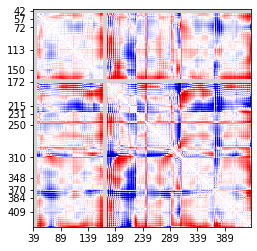

In [16]:
first_aligned = np.where(~np.isnan(ddm_shifted))[0][0]
print("First aligned residue: " + str(first_aligned))

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.set_aspect('equal')

# label axes with residue numbers, Y is beginning of each helix
ax1.set_xlim([first_aligned, len(ddm_shifted)])
ax1.set_ylim([len(ddm_shifted), first_aligned])
ax1.set_xticks(range(first_aligned, len(ddm_shifted), 50))
ax1.set_yticks(helix_starts)

# color unaligned positions light gray
ddm_masked = np.ma.masked_where(np.isnan(ddm_shifted), ddm_shifted)
palette = plt.cm.seismic
palette.set_bad(color="lightgray")
plt.imshow(ddm_shifted, vmin=-10, vmax=10, cmap=palette)
plt.show()

### 3. Helix-binning

To bin the DDM into helices, the DDM is divied into rectangular chunks. Within each chunk, the DDM values are then aggregated using a RMSD-like calculation (i.e. the entries of the DDM belonging to a chunk are squared, and the square-root of the average squared value represents each chunk/entry in the helix-binned DDM).

In [17]:
rmsd_ddm = [[0 for x in range(len(helix_starts))] for y in range(len(helix_starts))]
for i in range(len(helix_starts)):
    for j in range(len(helix_starts)):
        rmsd = 0
        numnotnan = 0
        for k in range(helix_starts[i], helix_ends[i]+1):
            for l in range(helix_starts[j], helix_ends[j]+1):
                if not (np.isnan(ddm_shifted[k][l])):
                    numnotnan += 1
                    rmsd += (ddm_shifted[k][l])**2
        rmsd_ddm[i][j] = np.sqrt(rmsd/(numnotnan+1))

# save to CSV, if desired
np.savetxt(outdir+a+'-vs-'+b+"-helices.csv", rmsd_ddm, delimiter=",")
print(outdir+a+'-vs-'+b+"-helices.csv has been saved.")

6c3iA-6d91A/6c3i_A-vs-6d91_A-helices.csv has been saved.


Finally, plot the helix-binned DDM:

<Figure size 432x288 with 0 Axes>

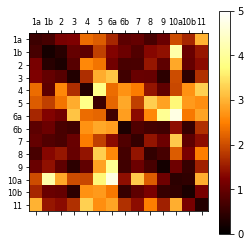

In [18]:
fig = plt.figure()
plt.matshow(rmsd_ddm, cmap=plt.cm.afmhot, vmin=0, vmax=5)
plt.xticks(np.arange(14), helix_names, fontsize=8)
plt.yticks(np.arange(14), helix_names, fontsize=8)
plt.colorbar()
plt.show()